In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1


In [ ]:
!pip install nlpaug -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 5.7 MB/s eta 0:00:00


# Part 1

In [ ]:
import json

file_paths = {
    'train': '/content/drive/MyDrive/TasD/coursework_dataset/train.json',
    'val': '/content/drive/MyDrive/TasD/coursework_dataset/val.json',
    'test': '/content/drive/MyDrive/TasD/coursework_dataset/test.json'
}

def load_and_summarize(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data
train_data = load_and_summarize(file_paths['train'])
val_data = load_and_summarize(file_paths['val'])
test_data = load_and_summarize(file_paths['test'])

print(train_data)


[{'question': 'how are glacier caves formed?', 'options': ['The ice facade is approximately 60 m high', 'A partly submerged glacier cave on Perito Moreno Glacier .', 'Ice formations in the Titlis glacier cave', 'A glacier cave is a cave formed within the ice of a glacier .'], 'correct_index': 3}, {'question': 'how much is 1 tablespoon of water', 'options': ['In the UK, Europe and most Commonwealth countries, a tablespoon is a type of large spoon usually used for serving.', 'In the US and parts of Canada, a tablespoon is the largest type of spoon used for eating from a bowl.', 'This tablespoon has a capacity of about 15 mL.', 'Measuring Spoons'], 'correct_index': 2}, {'question': 'how much are the harry potter movies worth', 'options': ['Harry Potter is a series of seven fantasy novels written by the British author J. K. Rowling .', "The main story arc concerns Harry's quest to overcome the Dark wizard Lord Voldemort , whose aims are to become immortal, conquer the wizarding world , sub

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
nlp.remove_pipe('lemmatizer')

('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7bf0d0840600>)

In [ ]:
def text_pipeline_spacy_special(text):
  tokens = []
  doc = nlp(text)
  for t in doc:
    if not t.is_punct and not t.is_space:
      tokens.append(t.text.lower())
  return tokens

def text_pipeline_spacy_special_with_stop(text):
  tokens = []
  doc = nlp(text)
  for t in doc:
    if not t.is_punct and not t.is_space and not t.is_stop:
      tokens.append(t.text.lower())
  return tokens

## (1.1) How many questions and options are there in each split? [1 mark]

In [ ]:
def count_questions_options(data):
    total_questions = len(data)
    for item in data:
      if(len(item['options'])!=4):
        print("OH NO") # seems that all questions have 4 options, very good
    total_options = sum(len(item['options']) for item in data)
    return total_questions, total_options

train_q, train_o = count_questions_options(train_data)
val_q, val_o = count_questions_options(val_data)
test_q, test_o = count_questions_options(test_data)

print(f'train data has {train_q} questions, {train_o} options.')
print(f'validation data has {val_q} questions, {val_o} options.')
print(f'test data has {test_q} questions, {test_o} options.')


train data has 741 questions, 2964 options.
validation data has 103 questions, 412 options.
test data has 202 questions, 808 options.


## (1.2) What is the average number of tokens per question in the training set? [1 mark]
## (1.3) What is the average number of tokens per choice in the training set? [1 mark]
## (1.4) What is the average number of tokens per correct choice in the training set? [1 mark]
## (1.5) Perform any additional exploration of the data that you feel would be helpful for this multiple-choice, question-answering task. Briefly describe what you found. [4 marks]

In [ ]:
import spacy
import json

def preprocessing_dataset(train_data):
  processed_train_data = []
  for item in train_data:
    processed_question = text_pipeline_spacy_special(item['question'])
    processed_options = [text_pipeline_spacy_special(option) for option in item['options']]
    correct_option_index = item['correct_index']
    processed_item = {
        'question': processed_question,
        'options': processed_options,
        'correct_index': correct_option_index
    }
    processed_train_data.append(processed_item)
  return processed_train_data

processed_train_data = preprocessing_dataset(train_data)

average_tokens_per_question = sum(len(item['question']) for item in processed_train_data) / len(processed_train_data)
average_tokens_per_option = sum(len(option) for item in processed_train_data for option in item['options']) / (len(processed_train_data) * 4)
average_tokens_per_correct_option = sum(len(item['options'][item['correct_index']]) for item in processed_train_data) / len(processed_train_data)

print(f"Average number of tokens per question: {average_tokens_per_question}")
print(f"Average number of tokens per option: {average_tokens_per_option}")
print(f"Average number of tokens per correct option: {average_tokens_per_correct_option}")


Average number of tokens per question: 6.272604588394062
Average number of tokens per option: 22.338056680161944
Average number of tokens per correct option: 26.032388663967613


In [ ]:
average_tokens_A_option = sum(len(item['options'][0]) for item in processed_train_data) / len(processed_train_data)
average_tokens_B_option = sum(len(item['options'][1]) for item in processed_train_data) / len(processed_train_data)
average_tokens_C_option = sum(len(item['options'][2]) for item in processed_train_data) / len(processed_train_data)
average_tokens_D_option = sum(len(item['options'][3]) for item in processed_train_data) / len(processed_train_data)
print(f"Average number of tokens A option: {average_tokens_A_option}")
print(f"Average number of tokens B option: {average_tokens_B_option}")
print(f"Average number of tokens C option: {average_tokens_C_option}")
print(f"Average number of tokens D option: {average_tokens_D_option}")
print()
from collections import Counter
unique_tokens = set(token for item in processed_train_data for token in item['question'])
for item in processed_train_data:
    for option in item['options']:
        unique_tokens.update(option)
vocabulary_diversity = len(unique_tokens)

average_tokens_in_wrong_options = sum(len(option) for item in processed_train_data for index, option in enumerate(item['options']) if index != item['correct_index']) / (len(processed_train_data) * 3)


token_frequency = Counter(token for item in processed_train_data for token in item['question'])
for item in processed_train_data:
    for option in item['options']:
        token_frequency.update(option)
most_common_tokens = token_frequency.most_common(10)

print(f"Vocabulary Diversity: {vocabulary_diversity}")
print(f"Average Number of Tokens in Wrong Options: {average_tokens_in_wrong_options}")
print()
print("Most Common Tokens and their Frequencies:")
for token, freq in most_common_tokens:
    print(f"{token}: {freq}")

Average number of tokens A option: 22.149797570850204
Average number of tokens B option: 22.527665317139
Average number of tokens C option: 22.178137651821864
Average number of tokens D option: 22.496626180836707

Vocabulary Diversity: 11676
Average Number of Tokens in Wrong Options: 21.106612685560055

Most Common Tokens and their Frequencies:
the: 5274
of: 2671
and: 2097
in: 1884
a: 1796
is: 1635
to: 1113
as: 722
by: 618
was: 547


In [ ]:
processed_train_data_stop = []
for item in train_data:
  processed_question = text_pipeline_spacy_special_with_stop(item['question'])
  processed_options = [text_pipeline_spacy_special_with_stop(option) for option in item['options']]
  correct_option_index = item['correct_index']
  processed_item = {
      'question': processed_question,
      'options': processed_options,
      'correct_index': correct_option_index
  }
  processed_train_data_stop.append(processed_item)

token_frequency = Counter(token for item in processed_train_data_stop for token in item['question'])
for item in processed_train_data_stop:
    for option in item['options']:
        token_frequency.update(option)
most_common_tokens = token_frequency.most_common(10)

print("Most Common Tokens and their Frequencies:")
for token, freq in most_common_tokens:
    print(f"{token}: {freq}")

Most Common Tokens and their Frequencies:
states: 310
united: 283
american: 190
known: 165
world: 157
war: 148
state: 110
city: 102
south: 90
new: 89


# Part 2
## (2.1) Report the performance of each similarity measure (overlap coefficient, Sorensen-Dice & Jaccard) on the training and validation sets by measuring accuracy. [6 marks]
## (2.2) For each similarity measure, how many times was the score of the most similar answer tied with another answer? When there was a tied score among the top answers, how did you choose which to select? Why? [4 marks]

In [ ]:
def overlap_coefficient(tokens_X, tokens_Y):
    tokens_X = set(tokens_X)
    tokens_Y = set(tokens_Y)
    intersection = tokens_X.intersection(tokens_Y)
    return len(intersection) / min(len(tokens_X), len(tokens_Y))

def jaccard_similarity(tokens_X, tokens_Y):
    tokens_X = set(tokens_X)
    tokens_Y = set(tokens_Y)
    intersection = tokens_X.intersection(tokens_Y)
    union = tokens_X.union(tokens_Y)
    return len(intersection) / len(union)

def sorensen_dice_coefficient(tokens_X, tokens_Y):
    tokens_X = set(tokens_X)
    tokens_Y = set(tokens_Y)
    intersection = tokens_X.intersection(tokens_Y)
    return 2 * len(intersection) / (len(tokens_X) + len(tokens_Y))


In [ ]:
import random
def calculate_accuracy(processed_data, similarity_function,select_type=0):
    correct_predictions = 0
    ties_count = 0
    for item in processed_data:
        question_tokens = item['question']
        options_tokens = item['options']
        correct_index = item['correct_index']
        scores = [similarity_function(question_tokens, option_tokens) for option_tokens in options_tokens]
        max_score = max(scores)
        if scores.count(max_score)>1:
          ties_count += 1
        if select_type == 0:
            chosen_index = scores.index(max_score)
        elif select_type == 1:
            max_length_indices = [i for i, score in enumerate(scores) if score == max_score]
            chosen_index = max(max_length_indices, key=lambda index: len(options_tokens[index]))
        elif select_type == 2:
            tied_options_indices = [i for i, score in enumerate(scores) if score == max_score]
            chosen_index = max(tied_options_indices, key=lambda index: len(set(options_tokens[index])))
        elif select_type == 3:
            tied_options_indices = [i for i, score in enumerate(scores) if score == max_score]
            chosen_index = random.choice(tied_options_indices)
        if chosen_index == correct_index:
            correct_predictions += 1
    accuracy = correct_predictions / len(processed_data)
    return accuracy,correct_predictions,ties_count

def calculate_with_three_similarity(processed_train_data,count):
  accuracy_overlap = calculate_accuracy(processed_train_data, overlap_coefficient,0)
  accuracy_jaccard = calculate_accuracy(processed_train_data, jaccard_similarity,0)
  accuracy_sorensen_dice = calculate_accuracy(processed_train_data, sorensen_dice_coefficient,0)
  print(f"Overlap Coefficient Accuracy: {accuracy_overlap[0]}, which is {accuracy_overlap[1]}/{count}")
  print(f"Jaccard Similarity Accuracy: {accuracy_jaccard[0]}, which is {accuracy_jaccard[1]}/{count}")
  print(f"Sorensen-Dice Coefficient Accuracy: {accuracy_sorensen_dice[0]}, which is {accuracy_sorensen_dice[1]}/{count}")

calculate_with_three_similarity(processed_train_data,train_q)


Overlap Coefficient Accuracy: 0.5236167341430499, which is 388/741
Jaccard Similarity Accuracy: 0.4291497975708502, which is 318/741
Sorensen-Dice Coefficient Accuracy: 0.4291497975708502, which is 318/741


In [ ]:
processed_val_data = preprocessing_dataset(val_data)
calculate_with_three_similarity(processed_val_data,val_q)

Overlap Coefficient Accuracy: 0.46601941747572817, which is 48/103
Jaccard Similarity Accuracy: 0.3592233009708738, which is 37/103
Sorensen-Dice Coefficient Accuracy: 0.3592233009708738, which is 37/103


In [ ]:
accuracy_overlap = calculate_accuracy(processed_train_data, overlap_coefficient)
accuracy_jaccard = calculate_accuracy(processed_train_data, jaccard_similarity)
accuracy_sorensen_dice = calculate_accuracy(processed_train_data, sorensen_dice_coefficient)
print(f"Train:Overlap Coefficient Ties_count {accuracy_overlap[2]}/{train_q}")
print(f"Train:Jaccard Similarity Ties_count {accuracy_jaccard[2]}/{train_q}")
print(f"Train:Sorensen-Dice Coefficient Ties_count {accuracy_sorensen_dice[2]}/{train_q}")
print('---------------------------------------------------------------')

def calculate_with_four_straties(similarity_function):
  accuracy_default = calculate_accuracy(processed_train_data, similarity_function, 0)
  accuracy_longest = calculate_accuracy(processed_train_data, similarity_function, 1)
  accuracy_most_complex = calculate_accuracy(processed_train_data, similarity_function, 2)
  accuracy_random = calculate_accuracy(processed_train_data, similarity_function, 3)
  print(similarity_function)
  print(f"Default Strategy Accuracy: {accuracy_default[0]}")
  print(f"Longest Option Strategy Accuracy: {accuracy_longest[0]}")
  print(f"Most Complex Option Strategy Accuracy: {accuracy_most_complex[0]}")
  print(f"Random Strategy Accuracy: {accuracy_most_complex[0]}")
  print('---------------------------------------------------------------')

calculate_with_four_straties(overlap_coefficient)
calculate_with_four_straties(jaccard_similarity)
calculate_with_four_straties(sorensen_dice_coefficient)

Train:Overlap Coefficient Ties_count 246/741
Train:Jaccard Similarity Ties_count 20/741
Train:Sorensen-Dice Coefficient Ties_count 20/741
---------------------------------------------------------------
<function overlap_coefficient at 0x7bf0d0871d80>
Default Strategy Accuracy: 0.5236167341430499
Longest Option Strategy Accuracy: 0.5357624831309041
Most Complex Option Strategy Accuracy: 0.5303643724696356
Random Strategy Accuracy: 0.5303643724696356
---------------------------------------------------------------
<function jaccard_similarity at 0x7bf0d0872050>
Default Strategy Accuracy: 0.4291497975708502
Longest Option Strategy Accuracy: 0.4358974358974359
Most Complex Option Strategy Accuracy: 0.43454790823211875
Random Strategy Accuracy: 0.43454790823211875
---------------------------------------------------------------
<function sorensen_dice_coefficient at 0x7bf0d0870820>
Default Strategy Accuracy: 0.4291497975708502
Longest Option Strategy Accuracy: 0.4358974358974359
Most Complex 

# Part 3
## (3.1) Report the performance of the training and validation sets by measuring accuracy. Discuss how they compare with the set similarity measures from Q2. [6 marks]
## (3.2) Propose, motivate, and evaluate one modification to this process to improve this method. Report the performance on the training and development sets and compare them with the unmodified version. [6 marks]

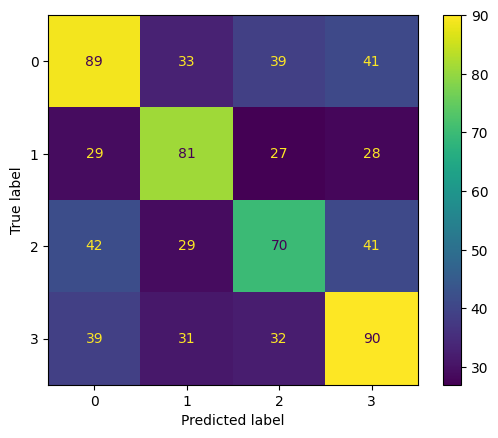

Train Accuracy: 0.44534412955465585
----------------------------------------


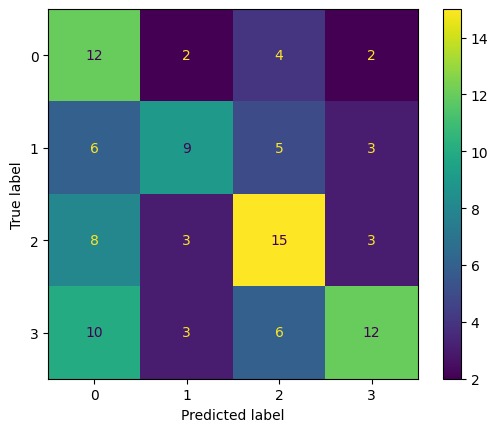

Validation Accuracy: 0.46601941747572817


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_accuracy_with_tf_and_optimization(processed_data):
    vectorizer = CountVectorizer()
    correct_answers = 0
    total_questions = len(processed_data)
    predicted_labels = []
    actual_labels = []

    for i, item in enumerate(processed_data):
        question = ' '.join(item['question'])
        options = [' '.join(option) for option in item['options']]
        correct_index = item['correct_index']
        vectorizer.fit([question] + options)
        tf_matrix = vectorizer.transform([question] + options)
        cosine_sim = cosine_similarity(tf_matrix[0:1], tf_matrix[1:])

        best_answer_index = np.argmax(cosine_sim)
        predicted_labels.append(best_answer_index)
        actual_labels.append(correct_index)

        if best_answer_index == correct_index:
            correct_answers += 1

    accuracy = correct_answers / total_questions

    cm = confusion_matrix(actual_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return accuracy

train_accuracy = calculate_accuracy_with_tf_and_optimization(processed_train_data)
print(f"Train Accuracy: {train_accuracy}")
print("----------------------------------------")
val_accuracy = calculate_accuracy_with_tf_and_optimization(processed_val_data)
print(f"Validation Accuracy: {val_accuracy}")


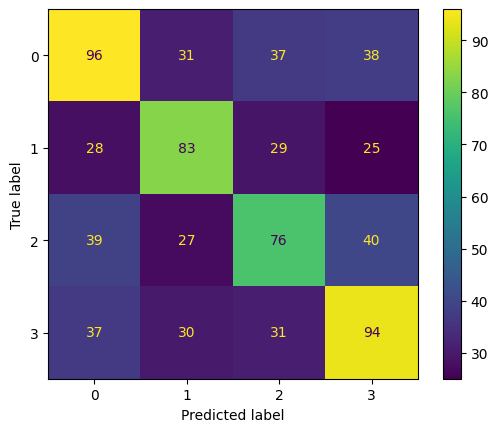

Train Accuracy: 0.4709851551956815
----------------------------------------


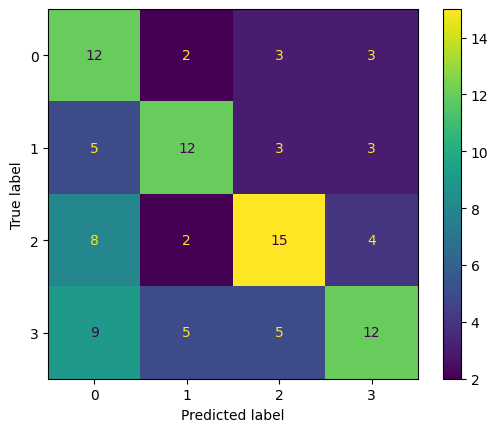

Validation Accuracy: 0.49514563106796117


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def calculate_accuracy_with_tfidf_and_optimization(processed_data):
    vectorizer = TfidfVectorizer()
    correct_answers = 0
    total_questions = len(processed_data)
    predicted_labels = []
    actual_labels = []

    for i, item in enumerate(processed_data):
        question = ' '.join(item['question'])
        options = [' '.join(option) for option in item['options']]
        correct_index = item['correct_index']
        vectorizer.fit([question] + options)
        tfidf_matrix = vectorizer.transform([question] + options)
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])

        best_answer_index = np.argmax(cosine_sim)
        predicted_labels.append(best_answer_index)
        actual_labels.append(correct_index)

        if best_answer_index == correct_index:
            correct_answers += 1

    accuracy = correct_answers / total_questions

    cm = confusion_matrix(actual_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    return accuracy

train_accuracy = calculate_accuracy_with_tfidf_and_optimization(processed_train_data)
print(f"Train Accuracy: {train_accuracy}")
print("----------------------------------------")
val_accuracy = calculate_accuracy_with_tfidf_and_optimization(processed_val_data)
print(f"Validation Accuracy: {val_accuracy}")



# Part 4
## (4.1) Report the performance of the training and validation sets by measuring accuracy. [8 marks]

In [ ]:
from transformers import AutoTokenizer, AutoModel,pipeline
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach()
    return cls_embedding.cpu()

def get_cls_average_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.detach()
    average_embedding = embeddings.mean(dim=1).unsqueeze(0)
    return average_embedding.cpu()

def calculate_accuracy_with_bert_embeddings(processed_data):
    correct_predictions = 0
    all_predictions = []
    all_actuals = []

    for item in processed_data:
        question_embedding = get_cls_average_embedding(' '.join(item['question']))
        options_embeddings = torch.vstack([get_cls_average_embedding(' '.join(option)) for option in item['options']])

        question_embedding = question_embedding.squeeze(0)
        options_embeddings = options_embeddings.squeeze(1)


        cosine_sim = cosine_similarity(question_embedding, options_embeddings)
        predicted = np.argmax(cosine_sim)
        actual = item['correct_index']

        all_predictions.append(predicted)
        all_actuals.append(actual)

        if predicted == actual:
            correct_predictions += 1

    accuracy = correct_predictions / len(processed_data)
    return accuracy, all_predictions, all_actuals

def plot_confusion_matrix(all_actuals, all_predictions):
    cm = confusion_matrix(all_actuals, all_predictions, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def display_first_question_and_embeddings(processed_data):
    for i, item in enumerate(processed_data):
        if i == 0:
            question = ' '.join(item['question'])
            options = [' '.join(option) for option in item['options']]

            print("Question:", question)
            question_embedding = get_cls_average_embedding(question)
            print("Question Embedding:", question_embedding.numpy())

            for j, option in enumerate(options):
                print(f"Option {j}:", option)
                option_embedding = get_cls_average_embedding(option)
                print(f"Option {j} Embedding:", option_embedding.numpy())
            break



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training Accuracy: 0.4048582995951417
Validation Accuracy: 0.4368932038834951


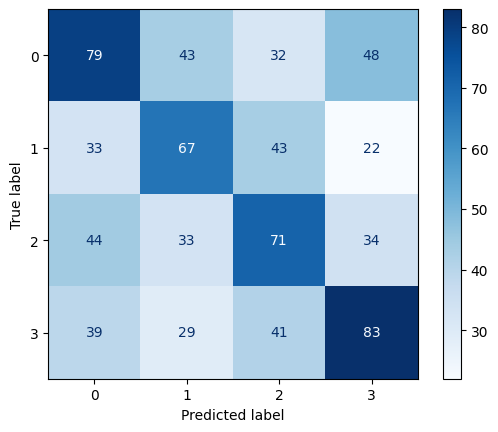

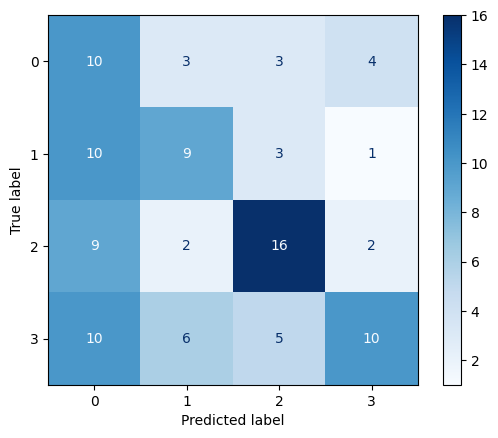

In [ ]:
train_accuracy, train_predictions, train_actuals = calculate_accuracy_with_bert_embeddings(processed_train_data)
val_accuracy, val_predictions, val_actuals = calculate_accuracy_with_bert_embeddings(processed_val_data)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

plot_confusion_matrix(train_actuals, train_predictions)
plot_confusion_matrix(val_actuals, val_predictions)


## (4.2) What are the limitations of the set similarity and cosine similarity methods used in Q2, Q3 and Q4? [4 marks]

In Q4, we directly applied feature extraction using the bert-base-uncased model to assess the cosine similarity between questions and their options, which yielded surprisingly poor results. This outcome, though unexpected, serves as a crucial discovery, highlighting the limitations of applying a pre-trained model without task-specific fine-tuning.The reasons may include, but are not limited to:

- **Lack of Task-Specific Optimization**: Pre-trained models might not fully grasp the complex semantic relationships between questions and options because they haven't been optimized for a specific task.

- **Insufficient Detail from [CLS] Vectors**: While [CLS] vectors capture the context of the entire input sequence, they may not distinguish between very similar text fragments finely enough.

- **Limitations of Cosine Similarity**: Although cosine similarity is a method to measure the similarity between text vectors, it might not capture the subtle semantic differences between texts adequately.

### Limitations in Q2

In Q2, we employed set similarity measures (like Jaccard similarity, Sorensen-Dice coefficient, and Overlap coefficient) to assess the similarity between texts. These methods, grounded in set theory, compare the overlap between two sets of texts (e.g., sets of words), with limitations including:

Ignoring Word Order and Context: Set similarity methods typically overlook the order of words and their contextual environment within texts, potentially reducing accuracy in understanding semantic relationships.

Simplified Text Representation: These approaches reduce texts to sets of words, ignoring the semantic complexity and polysemy of words, possibly failing to capture more subtle semantic differences between texts.

### Limitations in Q3

In Q3, we calculated cosine similarity using [CLS] vectors derived from the bert-base-uncased model. Although this approach better captures the text's context compared to Q2's methods, it still has limitations:

Fixed Vector Representation: Compressing each text into a fixed-size vector might lose some information crucial for specific tasks.

Unfine-tuned Pre-trained Model: If the pre-trained model is used directly without task-specific fine-tuning, it might not fully adapt to the specific demands of the task, leading to suboptimal performance.

### Limitations in Q4

In Q4, the direct application of pre-trained model feature extraction for assessing similarity between questions and options yielded the lowest accuracy. The primary limitations of this approach include:

Lack of Targeted Optimization: Unlike Q3, we did not fine-tune or optimize the model in any way in Q4, which is likely a significant reason for the low accuracy.

Over-reliance on [CLS] Vectors: Relying solely on the [CLS] vector to represent the entire text might not capture all information useful for the task, especially in differentiating very similar options.

### Reason for Accuracy Ranking (Q3 > Q2 > Q4)

Q3 outperforms Q2 because Q3 utilizes the BERT model's [CLS] vector, capturing the text's context more comprehensively, whereas Q2's methods ignore word order and context.

Q2 outperforms Q4 possibly because Q4 directly applies an unfine-tuned BERT model without targeted optimization, while Q2's set similarity methods, though simplistic, may suffice to distinguish between options in some cases.

Q4's performance is the lowest, emphasizing the importance of fine-tuning pre-trained models for specific tasks and the potential loss of information from solely relying on [CLS] vectors.

This series of comparisons and analyses underscores the importance of fine-tuning models for specific tasks and considerations when choosing appropriate text similarity calculation methods

# Part 5
## (5.1) Report the accuracy, precision, recall and F1 score of the predictions on the question-option pairs representation of the training and validation sets [10 marks]
## (5.2) Report the accuracy for this method for selecting the correct answer on the training and validation sets of this model. Note this is different from the value in part (a). To enable this, select the option for each question with the highest output logit value for the positive class of the model. [6 marks]
## (5.3) Why would you expect this approach to outperform the use of [CLS] vectors described in Q4? [2 marks]

In [ ]:
from torch.utils.data import Dataset
import nlpaug.augmenter.word as naw
from transformers import DataCollatorWithPadding
import random,re

class QADataset(Dataset):
    def __init__(self, data, tokenizer, augment=False):
        self.tokenizer = tokenizer
        self.inputs = []
        self.labels = []
        self.augment = augment
        self.aug = naw.ContextualWordEmbsAug(
            model_path='bert-base-uncased', action="substitute", device='cuda') if augment else None
        for item in data:
            question = item['question']
            for idx, option in enumerate(item['options']):
                text = f"{question} [SEP] {option}"
                self.inputs.append(text)
                self.labels.append(1 if idx == item['correct_index'] else 0)
    def get_item_label(self,idx):
      return self.labels[idx]

    def augment_text(self, text):
      augmented_text = self.aug.augment(text)
      return augmented_text

    def get_item_text(self, idx):
      return self.inputs[idx]

    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        text = self.inputs[idx]
        if self.augment:
            text = self.augment_text(text)
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        label = self.labels[idx]
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs['labels'] = label
        return inputs

train_dataset = QADataset(train_data, tokenizer, augment=False)
val_dataset = QADataset(val_data, tokenizer, augment=False)


In [ ]:
from transformers import AutoModelForSequenceClassification
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer,max_length=512)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    learning_rate=1e-5,
    weight_decay=0,
)

trainer = Trainer(
    model=model,
    args=training_args,
    # data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Step,Training Loss
500,0.504300
1000,0.412400


TrainOutput(global_step=1484, training_loss=0.41102868463151215, metrics={'train_runtime': 1111.736, 'train_samples_per_second': 10.664, 'train_steps_per_second': 1.335, 'total_flos': 3119444672348160.0, 'train_loss': 0.41102868463151215, 'epoch': 4.0})

In [ ]:
eval_result = trainer.evaluate()
print(eval_result)

{'eval_loss': 0.4792861342430115, 'eval_runtime': 13.5324, 'eval_samples_per_second': 30.445, 'eval_steps_per_second': 3.843, 'epoch': 4.0}


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
train_predictions, train_labels, _ = trainer.predict(train_dataset)
train_pred_labels = np.argmax(train_predictions, axis=1)

train_accuracy = accuracy_score(train_labels, train_pred_labels)
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_labels, train_pred_labels, average='binary')

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")

Train Accuracy: 0.8974358974358975
Train Precision: 0.7674418604651163
Train Recall: 0.8461538461538461
Train F1 Score: 0.8048780487804877


In [ ]:
predictions, labels, _ = trainer.predict(val_dataset)

In [ ]:
pred_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, pred_labels, average='binary')

print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")


Validation Accuracy: 0.8106796116504854
Validation Precision: 0.6237623762376238
Validation Recall: 0.6116504854368932
Validation F1 Score: 0.6176470588235294


In [ ]:
def get_accuracy(predictions,labels):
  probabilities = np.exp(predictions) / np.sum(np.exp(predictions), axis=-1, keepdims=True)
  prob_class_1 = probabilities[:, 1]
  correct_answers = 0
  total_questions = len(labels) // 4

  for i in range(0, len(labels), 4):
    group_prob_class_1 = prob_class_1[i:i+4]
    highest_prob_index = np.argmax(group_prob_class_1)
    if labels[i + highest_prob_index] == 1:
        correct_answers += 1

  accuracy = correct_answers / total_questions
  print(f"Accuracy: {accuracy:.4f}")

get_accuracy(train_predictions,train_labels)
get_accuracy(predictions,labels)

Accuracy: 0.8543
Accuracy: 0.6699


# Part 6
## (6.1) Report the accuracy using your best method on the test set. Use the performance on the validation set to select the best method. [2 marks]

In [ ]:
test_dataset = QADataset(test_data, tokenizer, augment=False)
predictions, labels, _ = trainer.predict(test_dataset)

get_accuracy(predictions,labels)


Accuracy: 0.6436


## (6.2) Discuss whether the achieved accuracy would be sufficient for deployment [2 marks]


Considering a test accuracy of 65%, this indicates that the model can correctly predict about two-thirds of the questions. Such accuracy might be acceptable in some application scenarios, especially those with a relatively high tolerance for errors, such as preliminary content recommendations, user engagement enhancements, or as an auxiliary tool in educational applications. In these cases, the model can serve as a useful aid to help users filter potentially valuable content from a vast amount of information or provide preliminary guidance, with the final decisions still left to the users.

However, if the application scenario demands high accuracy, such as in professional knowledge Q&A systems, medical consultations, or legal advisory services, a 65% accuracy rate is clearly insufficient. In these fields, incorrect information could lead to serious consequences, and users rely on the system's information to make important decisions. Therefore, it is necessary to improve accuracy through more in-depth model training, data augmentation, optimization of the model structure, etc.

In summary, while a 65% accuracy rate might be considered sufficient for some lightweight or preliminary applications, this performance level is far from adequate for scenarios requiring high-precision predictions. As a responsible researcher, I suggest further enhancing the model's performance before actual deployment to ensure it can provide high-quality, reliable predictions in the targeted application scenarios. Additionally, considering introducing a manual review mechanism as a supplement should also be considered to improve the overall system's accuracy and reliability.